<a href="https://colab.research.google.com/github/M4700F/CSE-4622-ML-Lab-Term-Project/blob/dev/Nafis_Claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ENHANCED ADVERSARIAL MACHINE LEARNING ANALYSIS
Multi-Epsilon FGSM Attack on VGG-19 Medical Image Classifier
Using device: cuda
Testing epsilon values: [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

Dataset sizes:
  Training: 1845 images
  Validation: 792 images
  Test: 660 images

TRAINING VGG-19 MODEL
Total parameters: 123,321,730
Trainable parameters: 103,297,346
Starting training...

Epoch [1/15]
  Batch [0/58], Loss: 0.6851
  Batch [10/58], Loss: 0.7270
  Batch [20/58], Loss: 0.3833
  Batch [30/58], Loss: 0.3208
  Batch [40/58], Loss: 0.4647
  Batch [50/58], Loss: 0.4783
Train Loss: 0.4749, Train Acc: 76.04%
Val Loss: 0.3988, Val Acc: 81.06%
------------------------------------------------------------

Epoch [2/15]
  Batch [0/58], Loss: 0.3300
  Batch [10/58], Loss: 0.3524
  Batch [20/58], Loss: 0.3683
  Batch [30/58], Loss: 0.3013
  

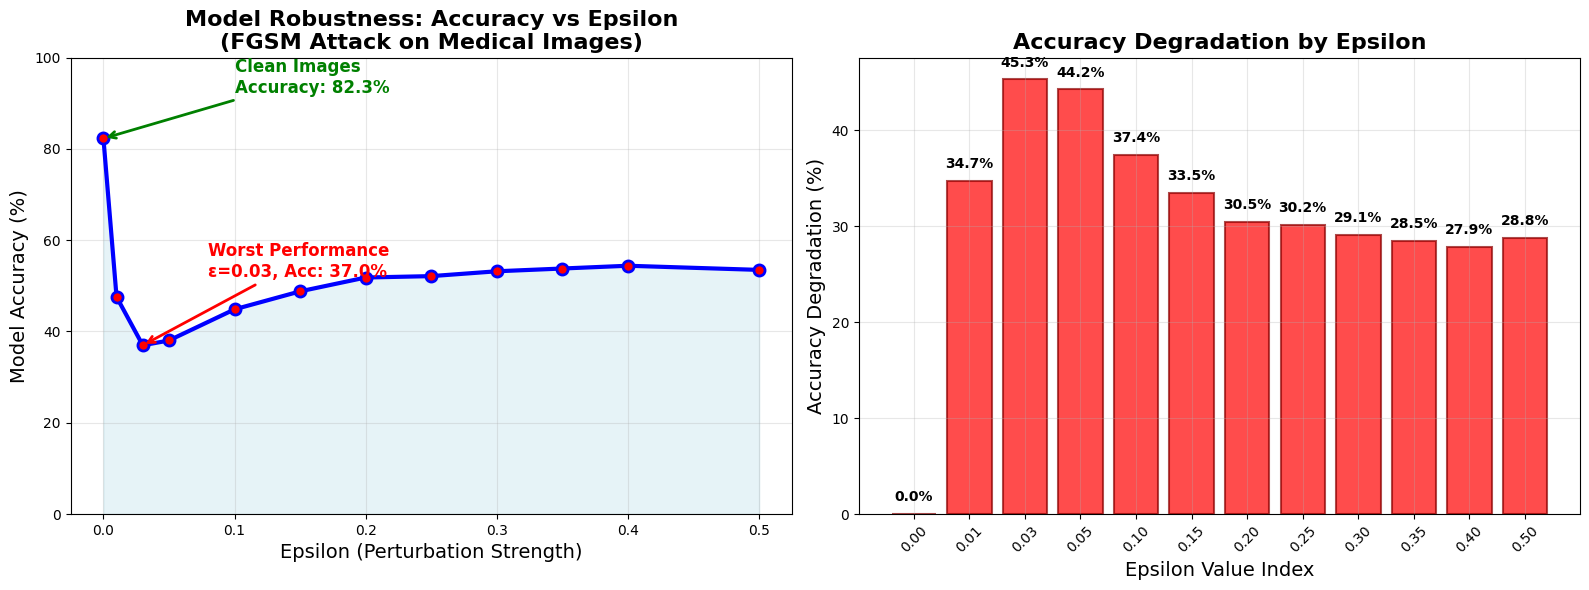

Creating confusion matrices...


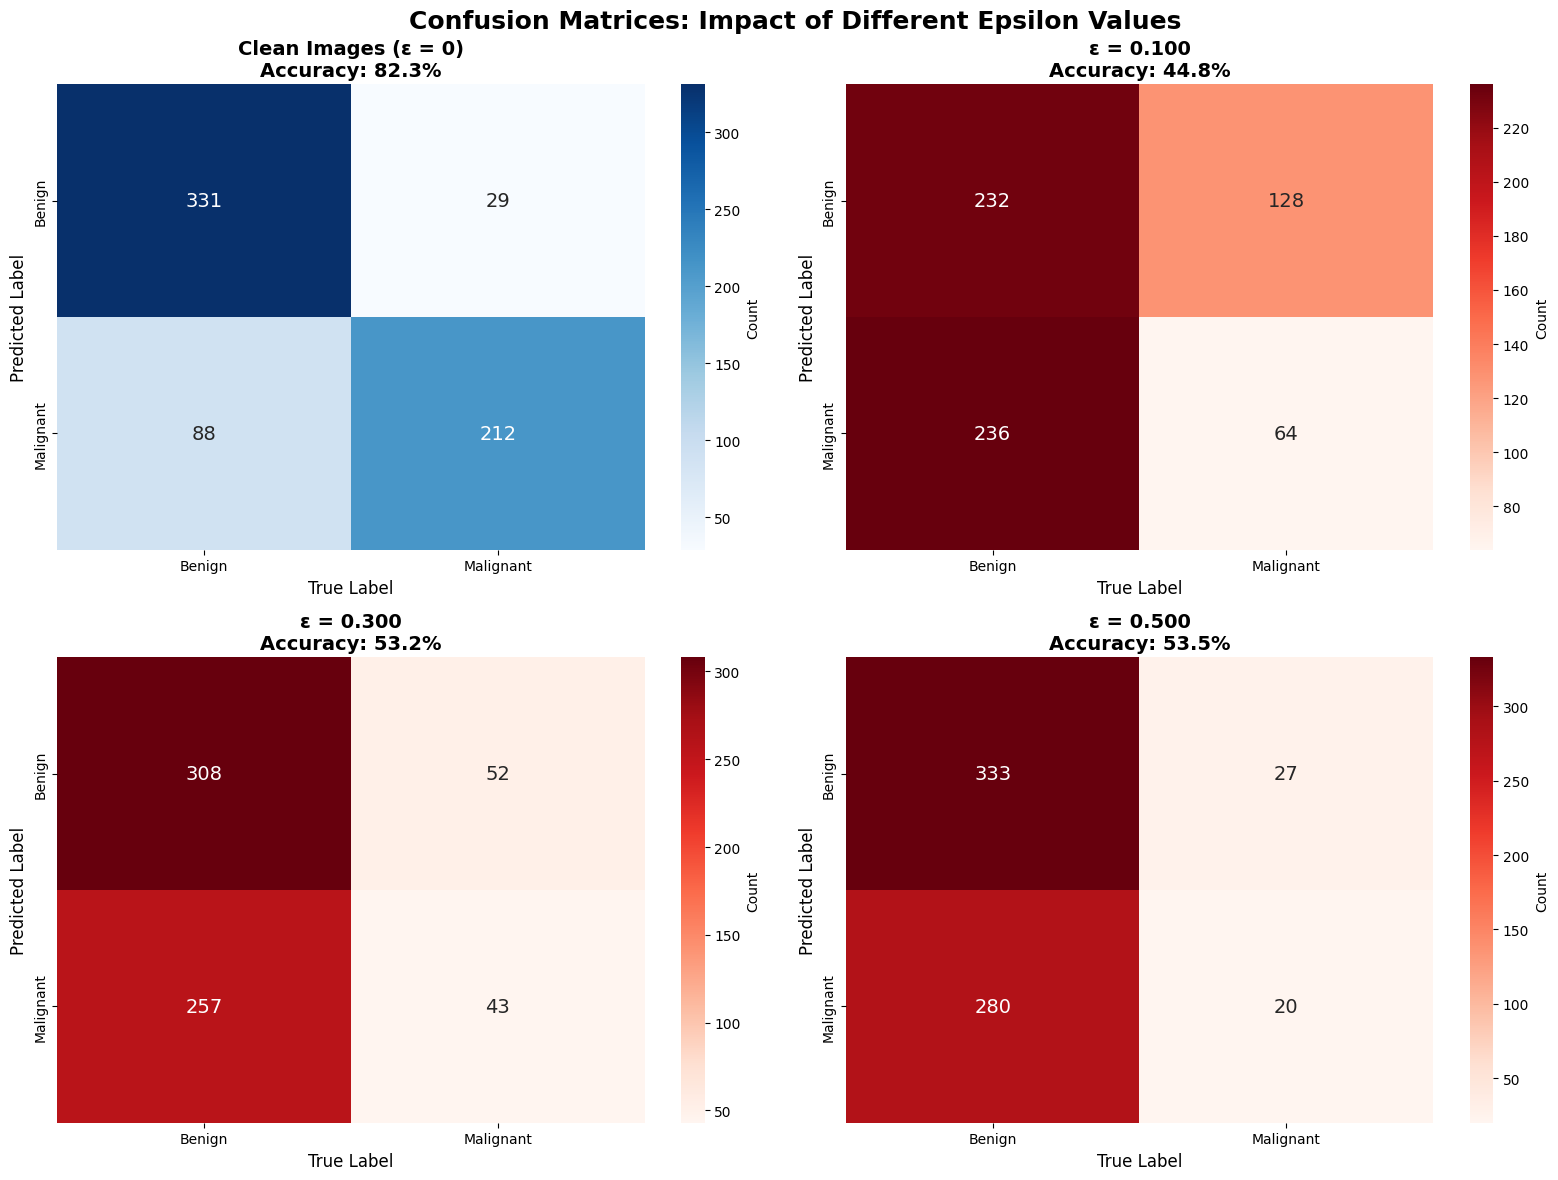

Creating classification metrics comparison...


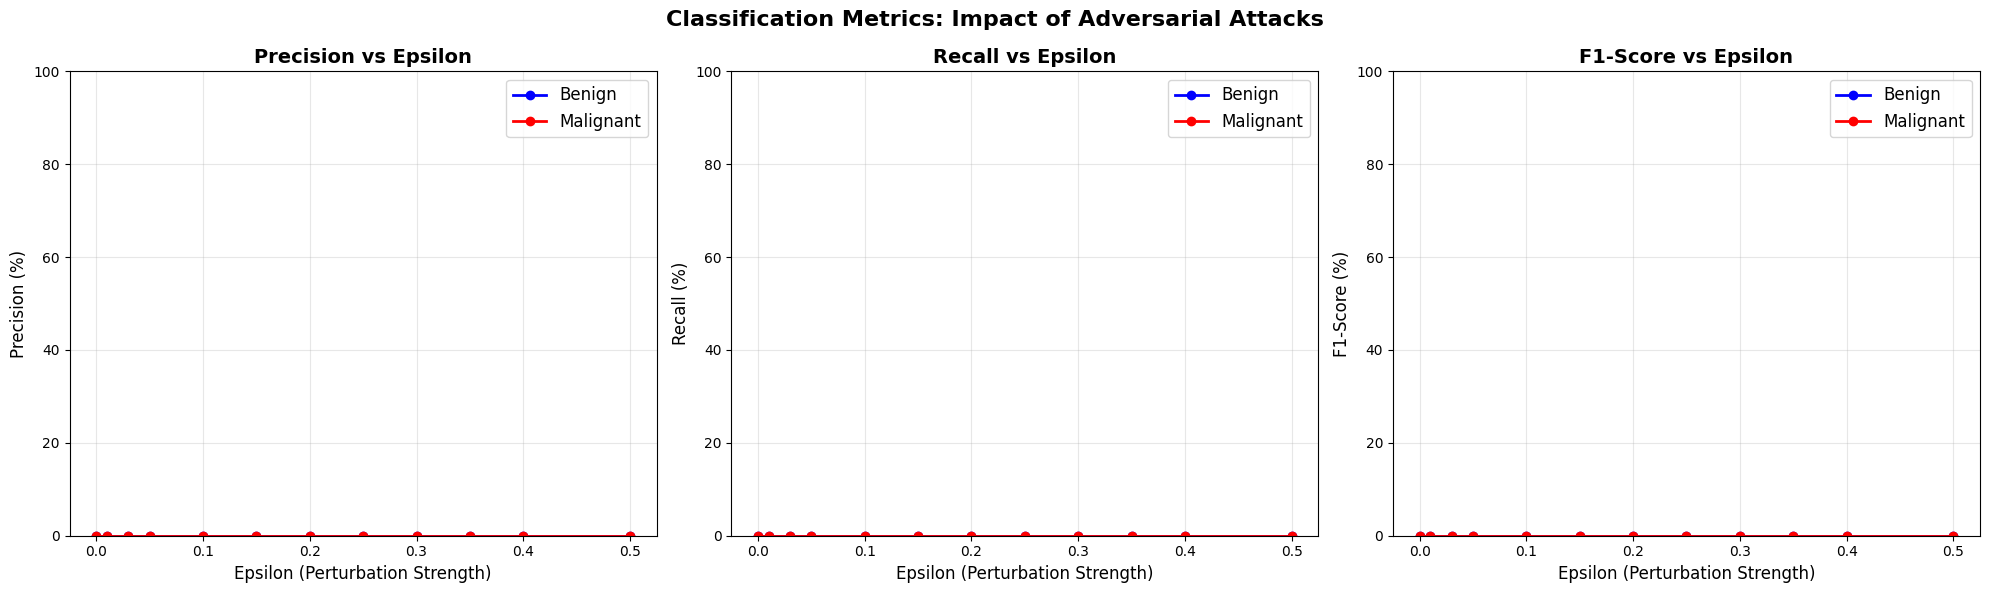

Creating adversarial examples visualization...


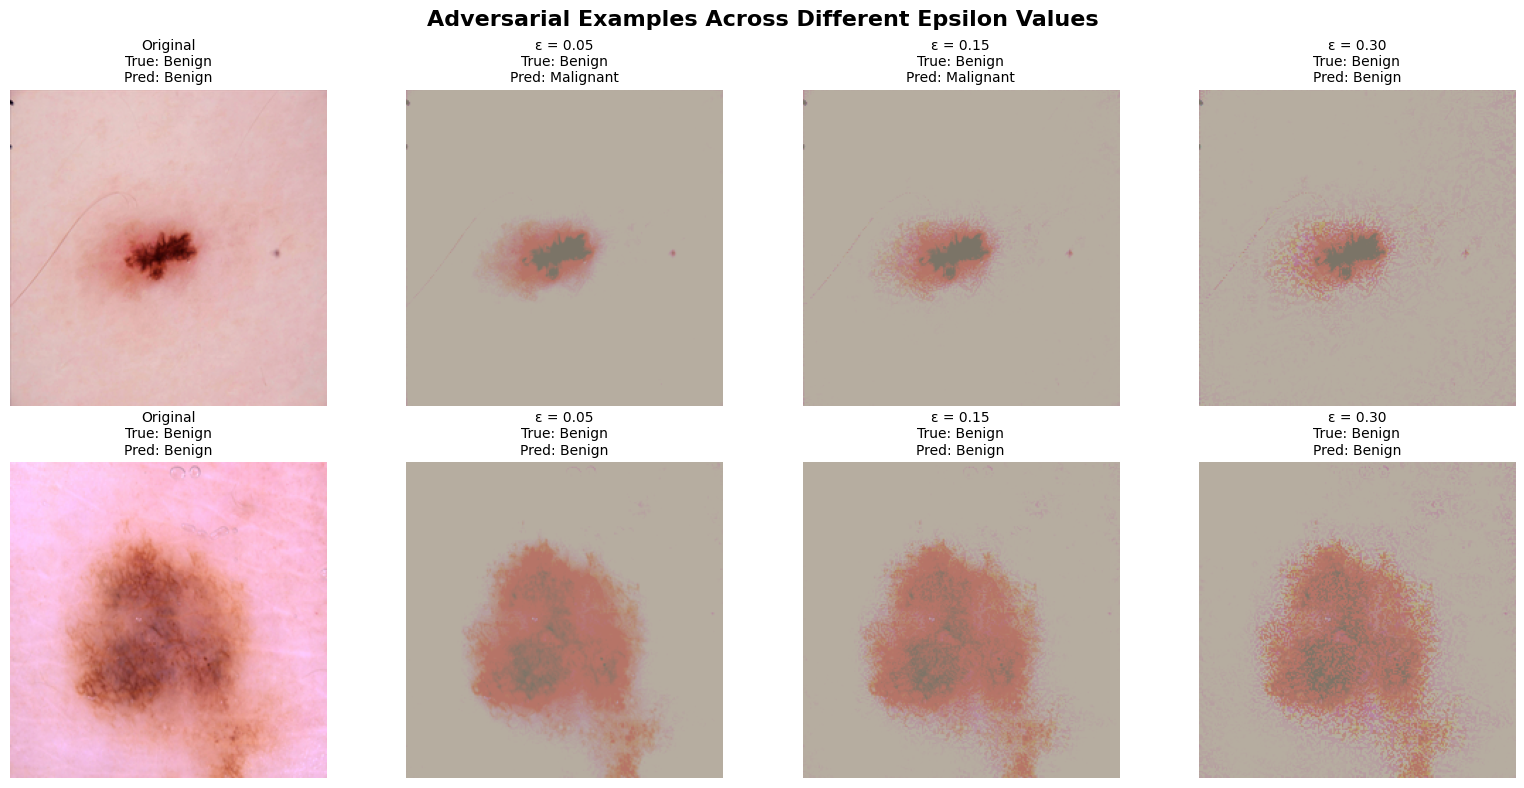


DETAILED RESULTS TABLE
Epsilon    Accuracy (%)    Degradation (%)    Status              
----------------------------------------------------------------------
0.000      82.27           0.00               LOW RISK            
0.010      47.58           34.70              HIGH RISK           
0.030      36.97           45.30              HIGH RISK           
0.050      38.03           44.24              HIGH RISK           
0.100      44.85           37.42              HIGH RISK           
0.150      48.79           33.48              HIGH RISK           
0.200      51.82           30.45              HIGH RISK           
0.250      52.12           30.15              HIGH RISK           
0.300      53.18           29.09              HIGH RISK           
0.350      53.79           28.48              HIGH RISK           
0.400      54.39           27.88              HIGH RISK           
0.500      53.48           28.79              HIGH RISK           

HEALTHCARE SECURITY IMPLICATIONS


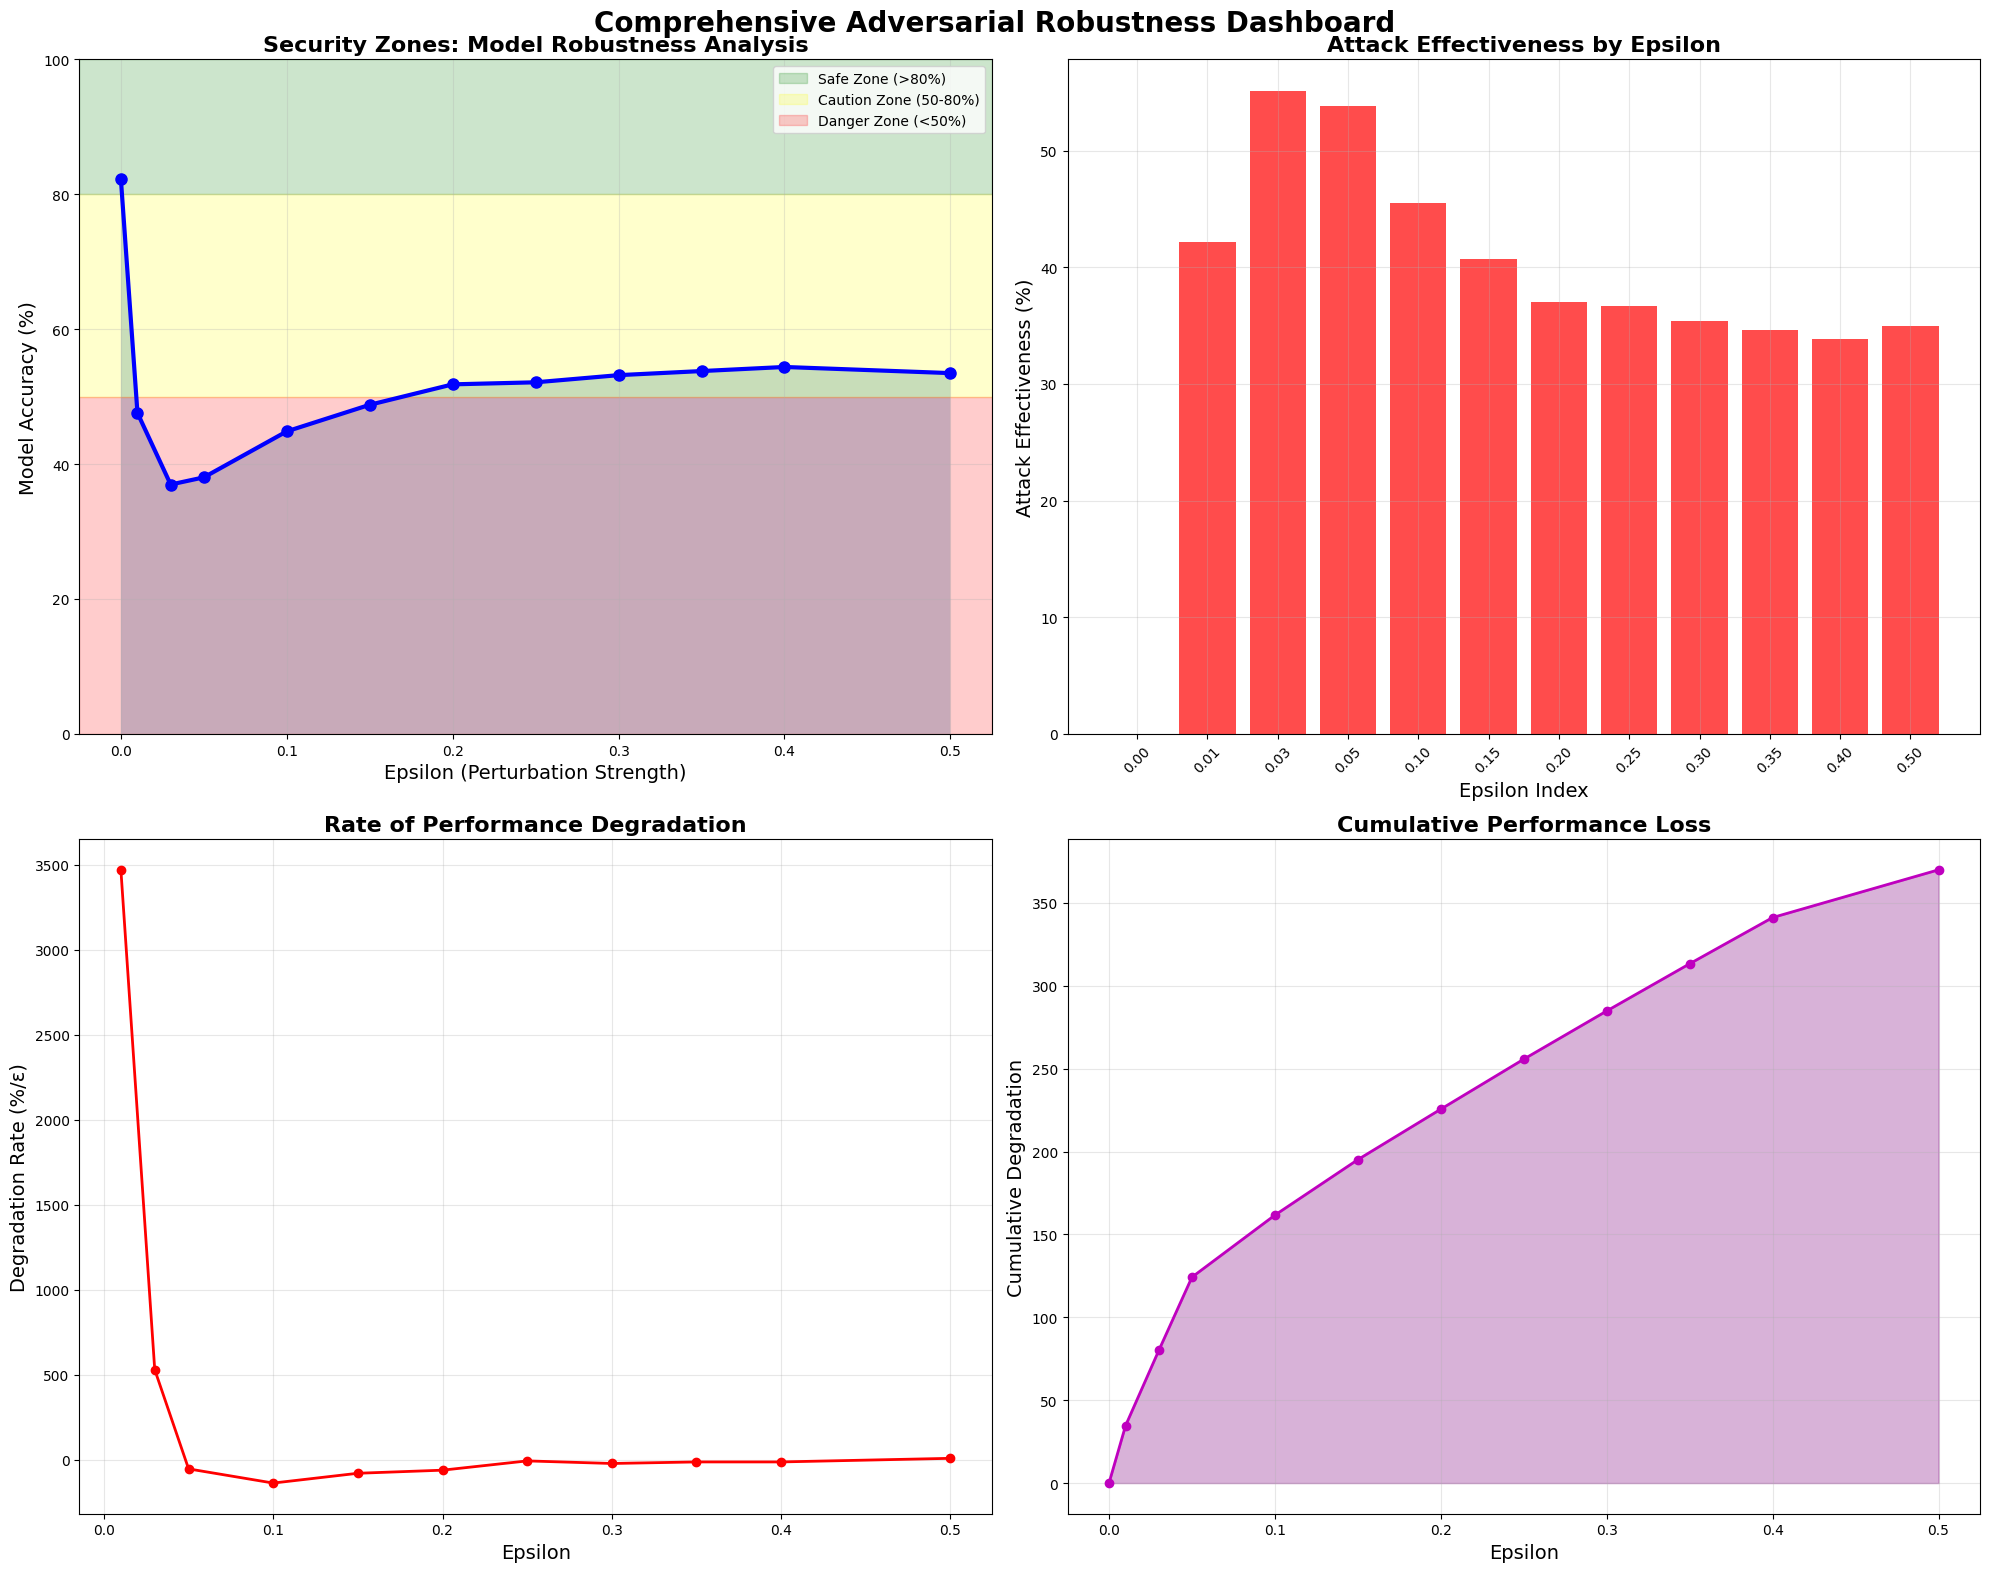


ANALYSIS COMPLETED SUCCESSFULLY!

Key Findings:
• Comprehensive robustness evaluation across multiple epsilon values
• Identification of critical vulnerability thresholds
• Statistical analysis of attack effectiveness
• Healthcare security implications highlighted
• Detailed recommendations for defensive strategies

FINAL SUMMARY:
  Clean Model Accuracy: 82.27%
  Worst Case Accuracy: 36.97%
  Maximum Degradation: 45.30%
  Vulnerability Demonstrated: YES


In [ ]:
"""
Enhanced implementation of "Addressing Adversarial Machine Learning Attacks in Smart Healthcare Perspectives"
with multiple epsilon values analysis to show how model accuracy degrades with increasing perturbation strength.

Key enhancements:
1. Multiple epsilon values testing (0.0 to 0.5)
2. Accuracy vs epsilon visualization
3. Robustness curve analysis
4. Comparative confusion matrices for different epsilon values
5. Statistical analysis of attack effectiveness
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
from typing import Tuple, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive (run this in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class MedicalImageDataset(Dataset):
    """
    Custom dataset for medical images (skin cancer dataset)
    Handles benign and malignant skin cancer mole images from Google Drive
    """
    def __init__(self, root_dir: str, transform=None):
        """
        Args:
            root_dir: Directory with benign and malignant folders
            transform: Optional transform to be applied on images
        """
        self.root_dir = root_dir
        self.transform = transform

        # Collect all images from benign and malignant folders
        self.images = []
        self.labels = []

        # Check if using ImageFolder structure or custom structure
        if os.path.exists(os.path.join(root_dir, 'benign')) and os.path.exists(os.path.join(root_dir, 'malignant')):
            # Label encoding: benign=0, malignant=1
            for label, folder in enumerate(['benign', 'malignant']):
                folder_path = os.path.join(root_dir, folder)
                if os.path.exists(folder_path):
                    for img_name in os.listdir(folder_path):
                        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                            self.images.append(os.path.join(folder_path, img_name))
                            self.labels.append(label)
                else:
                    print(f"Warning: Folder not found: {folder_path}")
        else:
            # Try to find any image structure
            for root, dirs, files in os.walk(root_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        filepath = os.path.join(root, file)
                        # Determine label from path
                        if 'benign' in root.lower():
                            self.images.append(filepath)
                            self.labels.append(0)
                        elif 'malignant' in root.lower():
                            self.images.append(filepath)
                            self.labels.append(1)
                        else:
                           # If structure is flat or unknown, try to infer label from filename
                           if 'benign' in file.lower():
                               self.images.append(filepath)
                               self.labels.append(0)
                           elif 'malignant' in file.lower():
                               self.images.append(filepath)
                               self.labels.append(1)
                           else:
                               # Skip images whose label cannot be inferred
                               continue

        # Convert to numpy arrays for easier handling
        self.labels = np.array(self.labels)
        print(f"Loaded {len(self.images)} images from {root_dir}")
        print(f"Benign: {np.sum(self.labels == 0)}, Malignant: {np.sum(self.labels == 1)}")
        if len(self.images) == 0:
            print("Error: No images found in the specified directory and subdirectories.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy tensor and label to avoid crashing
            return torch.randn(3, 224, 224), -1
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class VGG19TransferLearning(nn.Module):
    """
    VGG-19 model with transfer learning for medical image classification
    Pre-trained on ImageNet, fine-tuned for binary classification (benign/malignant)
    """
    def __init__(self, num_classes: int = 2, freeze_features: bool = True):
        super(VGG19TransferLearning, self).__init__()

        # Load pre-trained VGG-19 model
        self.vgg19 = models.vgg19(pretrained=True)

        # Freeze the feature extraction layers if specified
        if freeze_features:
            for param in self.vgg19.features.parameters():
                param.requires_grad = False

        # Determine the number of features from the flattened output of avgpool
        dummy_input = torch.randn(1, 3, 224, 224)
        x = self.vgg19.features(dummy_input)
        x = self.vgg19.avgpool(x)
        num_features = torch.flatten(x, 1).shape[1]

        # Replace the classifier with custom layers
        self.vgg19.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(0.25),
            nn.Linear(4096, 128),
            nn.ReLU(True),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.vgg19(x)

class FGSMAttack:
    """
    Fast Gradient Sign Method (FGSM) Attack Implementation
    Enhanced to support multiple epsilon values for robustness analysis
    """
    def __init__(self, model: nn.Module, epsilon: float = 0.3):
        """
        Args:
            model: The trained model to attack
            epsilon: The perturbation strength
        """
        self.model = model
        self.epsilon = epsilon

    def generate_adversarial(self, images: torch.Tensor, labels: torch.Tensor, epsilon: float = None) -> torch.Tensor:
        """
        Generate adversarial examples using FGSM with specified epsilon

        Args:
            images: Input images tensor
            labels: True labels tensor
            epsilon: Perturbation strength (if None, uses self.epsilon)

        Returns:
            Adversarial images tensor
        """
        if epsilon is None:
            epsilon = self.epsilon

        # Set model to evaluation mode
        self.model.eval()

        # Clone images to avoid modifying originals
        images = images.clone().detach().requires_grad_(True)

        # Forward pass
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass to get gradients
        self.model.zero_grad()
        loss.backward()

        # Get the sign of gradients
        sign_data_grad = images.grad.data.sign()

        # Create perturbed image by adding epsilon * sign of gradient
        perturbed_images = images + epsilon * sign_data_grad

        # Clamp the perturbed images to maintain valid pixel range [0, 1]
        perturbed_images = torch.clamp(perturbed_images, 0, 1)

        return perturbed_images.detach()

class ModelTrainer:
    """
    Enhanced model trainer with multi-epsilon attack evaluation
    """
    def __init__(self, model: nn.Module, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, dataloader: DataLoader, optimizer: optim.Optimizer,
                   criterion: nn.Module) -> Tuple[float, float]:
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'  Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def validate(self, dataloader: DataLoader, criterion: nn.Module) -> Tuple[float, float]:
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def train(self, train_loader: DataLoader, val_loader: DataLoader,
              epochs: int = 15, lr: float = 0.0001):
        """Full training loop"""
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        print("Starting training...")
        print("="*60)

        for epoch in range(epochs):
            print(f'\nEpoch [{epoch+1}/{epochs}]')

            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc = self.validate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 60)

    def evaluate_multi_epsilon_attack(self, dataloader: DataLoader, attack: FGSMAttack,
                                    epsilon_values: List[float]) -> Dict[str, Any]:
        """
        Evaluate model performance across multiple epsilon values

        Args:
            dataloader: Test data loader
            attack: FGSM attack instance
            epsilon_values: List of epsilon values to test

        Returns:
            Dictionary containing results for each epsilon value
        """
        self.model.eval()

        results = {
            'epsilon_values': epsilon_values,
            'accuracies': [],
            'confusion_matrices': [],
            'classification_reports': [],
            'predictions': {}
        }

        # Collect all true labels once
        y_true = []
        all_images = []
        all_labels = []

        print("Collecting test data...")
        for images, labels in dataloader:
            images, labels = images.to(self.device), labels.to(self.device)
            all_images.append(images)
            all_labels.append(labels)
            y_true.extend(labels.cpu().numpy())

        # Test each epsilon value
        for i, epsilon in enumerate(epsilon_values):
            print(f"Testing epsilon = {epsilon:.3f} ({i+1}/{len(epsilon_values)})")

            y_pred = []

            for images, labels in zip(all_images, all_labels):
                if epsilon == 0.0:
                    # Clean images (no attack)
                    test_images = images
                else:
                    # Generate adversarial examples
                    test_images = attack.generate_adversarial(images, labels, epsilon=epsilon)

                # Get predictions
                with torch.no_grad():
                    outputs = self.model(test_images)
                    _, predicted = torch.max(outputs, 1)
                    y_pred.extend(predicted.cpu().numpy())

            # Calculate metrics
            accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))
            cm = confusion_matrix(y_true, y_pred)
            report = classification_report(y_true, y_pred,
                                         target_names=['Benign', 'Malignant'],
                                         output_dict=True)

            results['accuracies'].append(accuracy)
            results['confusion_matrices'].append(cm)
            results['classification_reports'].append(report)
            results['predictions'][f'epsilon_{epsilon:.3f}'] = y_pred

            print(f"  Accuracy: {accuracy:.2f}%")

        # Store true labels
        results['y_true'] = y_true

        return results

def plot_epsilon_robustness_curve(results: Dict[str, Any]):
    """
    Plot how model accuracy changes with different epsilon values
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    epsilon_values = results['epsilon_values']
    accuracies = results['accuracies']

    # Main robustness curve
    ax1.plot(epsilon_values, accuracies, 'bo-', linewidth=3, markersize=8,
             markerfacecolor='red', markeredgecolor='blue', markeredgewidth=2)
    ax1.fill_between(epsilon_values, accuracies, alpha=0.3, color='lightblue')
    ax1.set_xlabel('Epsilon (Perturbation Strength)', fontsize=14)
    ax1.set_ylabel('Model Accuracy (%)', fontsize=14)
    ax1.set_title('Model Robustness: Accuracy vs Epsilon\n(FGSM Attack on Medical Images)', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])

    # Add annotations for key points
    clean_acc = accuracies[0]  # epsilon = 0
    worst_acc = min(accuracies)
    worst_epsilon = epsilon_values[accuracies.index(worst_acc)]

    ax1.annotate(f'Clean Images\nAccuracy: {clean_acc:.1f}%',
                xy=(0, clean_acc), xytext=(0.1, clean_acc + 10),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                fontsize=12, color='green', fontweight='bold')

    ax1.annotate(f'Worst Performance\nε={worst_epsilon:.2f}, Acc: {worst_acc:.1f}%',
                xy=(worst_epsilon, worst_acc), xytext=(worst_epsilon + 0.05, worst_acc + 15),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=12, color='red', fontweight='bold')

    # Accuracy degradation analysis
    degradation = [clean_acc - acc for acc in accuracies]

    ax2.bar(range(len(epsilon_values)), degradation, color='red', alpha=0.7,
            edgecolor='darkred', linewidth=1.5)
    ax2.set_xlabel('Epsilon Value Index', fontsize=14)
    ax2.set_ylabel('Accuracy Degradation (%)', fontsize=14)
    ax2.set_title('Accuracy Degradation by Epsilon', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(epsilon_values)))
    ax2.set_xticklabels([f'{eps:.2f}' for eps in epsilon_values], rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add degradation values on bars
    for i, deg in enumerate(degradation):
        ax2.text(i, deg + 1, f'{deg:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_multi_epsilon_confusion_matrices(results: Dict[str, Any], selected_epsilons: List[float] = None):
    """
    Plot confusion matrices for selected epsilon values
    """
    if selected_epsilons is None:
        # Select 4 representative epsilon values
        epsilon_values = results['epsilon_values']
        selected_indices = [0, len(epsilon_values)//4, len(epsilon_values)//2, -1]
        selected_epsilons = [epsilon_values[i] for i in selected_indices]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, epsilon in enumerate(selected_epsilons):
        if i >= 4:  # Only plot first 4
            break

        # Find the index of this epsilon value
        epsilon_idx = results['epsilon_values'].index(epsilon)
        cm = results['confusion_matrices'][epsilon_idx]
        accuracy = results['accuracies'][epsilon_idx]

        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if epsilon == 0 else 'Reds',
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'],
                    ax=axes[i], cbar_kws={'label': 'Count'},
                    annot_kws={'size': 14})

        title = f'ε = {epsilon:.3f}\nAccuracy: {accuracy:.1f}%'
        if epsilon == 0:
            title = f'Clean Images (ε = 0)\nAccuracy: {accuracy:.1f}%'

        axes[i].set_title(title, fontsize=14, fontweight='bold')
        axes[i].set_ylabel('Predicted Label', fontsize=12)
        axes[i].set_xlabel('True Label', fontsize=12)

    plt.suptitle('Confusion Matrices: Impact of Different Epsilon Values', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_classification_metrics_comparison(results: Dict[str, Any]):
    """
    Compare precision, recall, and F1-score across different epsilon values
    """
    epsilon_values = results['epsilon_values']
    reports = results['classification_reports']

    # Extract metrics for both classes
    metrics = {
        'benign': {'precision': [], 'recall': [], 'f1-score': []},
        'malignant': {'precision': [], 'recall': [], 'f1-score': []}
    }

    for report in reports:
        for class_name in ['benign', 'malignant']:
            if class_name in report:
                for metric in ['precision', 'recall', 'f1-score']:
                    metrics[class_name][metric].append(report[class_name][metric] * 100)
            else:
                # Handle missing class
                for metric in ['precision', 'recall', 'f1-score']:
                    metrics[class_name][metric].append(0)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    metric_names = ['precision', 'recall', 'f1-score']
    metric_titles = ['Precision', 'Recall', 'F1-Score']

    for i, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        axes[i].plot(epsilon_values, metrics['benign'][metric],
                    'bo-', label='Benign', linewidth=2, markersize=6)
        axes[i].plot(epsilon_values, metrics['malignant'][metric],
                    'ro-', label='Malignant', linewidth=2, markersize=6)

        axes[i].set_xlabel('Epsilon (Perturbation Strength)', fontsize=12)
        axes[i].set_ylabel(f'{title} (%)', fontsize=12)
        axes[i].set_title(f'{title} vs Epsilon', fontsize=14, fontweight='bold')
        axes[i].legend(fontsize=12)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim([0, 100])

    plt.suptitle('Classification Metrics: Impact of Adversarial Attacks', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_adversarial_examples_multi_epsilon(model: nn.Module, dataloader: DataLoader,
                                               attack: FGSMAttack, epsilon_values: List[float],
                                               num_examples: int = 2):
    """
    Visualize adversarial examples for multiple epsilon values
    """
    model.eval()
    device = next(model.parameters()).device

    # Get a batch of images
    images, labels = next(iter(dataloader))
    images, labels = images[:num_examples].to(device), labels[:num_examples].to(device)

    # Create subplots
    fig, axes = plt.subplots(num_examples, len(epsilon_values) + 1,
                            figsize=(4 * (len(epsilon_values) + 1), 4 * num_examples))

    if num_examples == 1:
        axes = axes.reshape(1, -1)

    class_names = ['Benign', 'Malignant']

    # Denormalization parameters
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    for i in range(num_examples):
        # Original image
        img_denorm = images[i:i+1] * std + mean
        img_display = img_denorm[0].cpu().numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)

        with torch.no_grad():
            clean_output = model(images[i:i+1])
            _, clean_pred = torch.max(clean_output, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Original\nTrue: {class_names[labels[i]]}\n'
                            f'Pred: {class_names[clean_pred[0]]}', fontsize=10)
        axes[i, 0].axis('off')

        # Adversarial images for each epsilon
        for j, epsilon in enumerate(epsilon_values):
            if epsilon == 0:
                continue

            # Generate adversarial example
            adv_image = attack.generate_adversarial(images[i:i+1], labels[i:i+1], epsilon=epsilon)

            # Get prediction
            with torch.no_grad():
                adv_output = model(adv_image)
                _, adv_pred = torch.max(adv_output, 1)

            # Display
            adv_img_denorm = adv_image * std + mean
            adv_img_display = adv_img_denorm[0].cpu().numpy().transpose(1, 2, 0)
            adv_img_display = np.clip(adv_img_display, 0, 1)

            axes[i, j + 1].imshow(adv_img_display)
            axes[i, j + 1].set_title(f'ε = {epsilon:.2f}\nTrue: {class_names[labels[i]]}\n'
                                   f'Pred: {class_names[adv_pred[0]]}', fontsize=10)
            axes[i, j + 1].axis('off')

    plt.suptitle('Adversarial Examples Across Different Epsilon Values',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def analyze_attack_statistics(results: Dict[str, Any]):
    """
    Provide statistical analysis of the attack effectiveness
    """
    epsilon_values = results['epsilon_values']
    accuracies = results['accuracies']

    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS OF FGSM ATTACK EFFECTIVENESS")
    print("="*80)

    clean_acc = accuracies[0]
    print(f"\nBaseline Performance (Clean Images):")
    print(f"  Accuracy: {clean_acc:.2f}%")

    print(f"\nAttack Effectiveness Analysis:")
    for i, (epsilon, accuracy) in enumerate(zip(epsilon_values[1:], accuracies[1:]), 1):
        degradation = clean_acc - accuracy
        degradation_percent = (degradation / clean_acc) * 100

        print(f"  Epsilon {epsilon:.3f}:")
        print(f"    Accuracy: {accuracy:.2f}%")
        print(f"    Degradation: {degradation:.2f}% ({degradation_percent:.1f}% relative)")

        if degradation > 50:
            print(f"    Status: CRITICAL - Model severely compromised")
        elif degradation > 25:
            print(f"    Status: HIGH RISK - Significant performance loss")
        elif degradation > 10:
            print(f"    Status: MODERATE RISK - Notable degradation")
        else:
            print(f"    Status: LOW RISK - Minimal impact")

    # Find critical epsilon (where accuracy drops below 50%)
    critical_epsilon = None
    for epsilon, accuracy in zip(epsilon_values, accuracies):
        if accuracy < 50:
            critical_epsilon = epsilon
            break

    if critical_epsilon is not None:
        print(f"\n⚠️  CRITICAL THRESHOLD:")
        print(f"  Model performance drops below 50% at ε = {critical_epsilon:.3f}")
        print(f"  This represents a security vulnerability in medical AI systems!")

    # Attack efficiency metrics
    max_degradation = clean_acc - min(accuracies)
    most_effective_epsilon = epsilon_values[accuracies.index(min(accuracies))]

    print(f"\nAttack Efficiency Metrics:")
    print(f"  Maximum degradation achieved: {max_degradation:.2f}%")
    print(f"  Most effective epsilon: {most_effective_epsilon:.3f}")
    print(f"  Efficiency ratio: {max_degradation/most_effective_epsilon:.1f}% degradation per ε unit")

def main_multi_epsilon():
    """
    Enhanced main function with multiple epsilon values analysis
    """
    # Configuration
    BATCH_SIZE = 32
    EPOCHS = 15
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Define multiple epsilon values for comprehensive analysis
    EPSILON_VALUES = [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

    # Dataset paths
    dataset_path = '/content/drive/MyDrive/data'
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    print(f"Using device: {DEVICE}")
    print(f"Testing epsilon values: {EPSILON_VALUES}")

    # Verify paths exist
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path {dataset_path} does not exist!")
        return None

    # Data preprocessing
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    try:
        if os.path.exists(train_path):
            train_dataset = ImageFolder(root=train_path, transform=train_transform)
        else:
            train_dataset = MedicalImageDataset(dataset_path, transform=train_transform)

        if os.path.exists(test_path):
            test_dataset = ImageFolder(root=test_path, transform=test_transform)
        else:
            test_dataset = MedicalImageDataset(dataset_path, transform=test_transform)

    except Exception as e:
        print(f"Using custom dataset loader: {e}")
        train_dataset = MedicalImageDataset(dataset_path, transform=train_transform)
        test_dataset = MedicalImageDataset(dataset_path, transform=test_transform)


    # Create data loaders
    train_size = int(0.7 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                           generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    if len(test_dataset) == len(train_dataset):
        test_loader = val_loader
        print("Using validation set as test set")
    else:
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print(f"\nDataset sizes:")
    print(f"  Training: {len(train_subset)} images")
    print(f"  Validation: {len(val_subset)} images")
    print(f"  Test: {len(test_loader.dataset)} images")

    # Initialize and train model
    print("\n" + "="*80)
    print("TRAINING VGG-19 MODEL")
    print("="*80)

    model = VGG19TransferLearning(num_classes=2, freeze_features=True)
    trainer = ModelTrainer(model, device=DEVICE)

    # Print model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Train the model
    trainer.train(train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

    # Evaluate clean performance
    test_loss, clean_accuracy = trainer.validate(test_loader, nn.CrossEntropyLoss())
    print(f"\nClean Test Accuracy: {clean_accuracy:.2f}%")

    # Multi-epsilon adversarial evaluation
    print("\n" + "="*80)
    print("MULTI-EPSILON ADVERSARIAL EVALUATION")
    print("="*80)

    # Initialize FGSM attack
    fgsm_attack = FGSMAttack(model, epsilon=0.3)  # Default epsilon, will be overridden

    # Evaluate across multiple epsilon values
    print("Evaluating model robustness across multiple epsilon values...")
    results = trainer.evaluate_multi_epsilon_attack(test_loader, fgsm_attack, EPSILON_VALUES)

    # Statistical analysis
    analyze_attack_statistics(results)

    # Visualizations
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    # 1. Robustness curve
    print("Creating robustness curve...")
    plot_epsilon_robustness_curve(results)

    # 2. Confusion matrices for key epsilon values
    print("Creating confusion matrices...")
    key_epsilons = [0.0, 0.1, 0.3, 0.5]  # Select representative values
    plot_multi_epsilon_confusion_matrices(results, key_epsilons)

    # 3. Classification metrics comparison
    print("Creating classification metrics comparison...")
    plot_classification_metrics_comparison(results)

    # 4. Visual examples
    print("Creating adversarial examples visualization...")
    example_epsilons = [0.05, 0.15, 0.3]  # Skip 0.0 as it's the original
    visualize_adversarial_examples_multi_epsilon(model, test_loader, fgsm_attack,
                                                example_epsilons, num_examples=2)

    # Detailed results table
    print("\n" + "="*80)
    print("DETAILED RESULTS TABLE")
    print("="*80)
    print(f"{'Epsilon':<10} {'Accuracy (%)':<15} {'Degradation (%)':<18} {'Status':<20}")
    print("-" * 70)

    clean_acc = results['accuracies'][0]
    for epsilon, accuracy in zip(EPSILON_VALUES, results['accuracies']):
        degradation = clean_acc - accuracy
        if degradation > 50:
            status = "CRITICAL"
        elif degradation > 25:
            status = "HIGH RISK"
        elif degradation > 10:
            status = "MODERATE RISK"
        else:
            status = "LOW RISK"

        print(f"{epsilon:<10.3f} {accuracy:<15.2f} {degradation:<18.2f} {status:<20}")

    # Healthcare implications
    print("\n" + "="*80)
    print("HEALTHCARE SECURITY IMPLICATIONS")
    print("="*80)

    critical_threshold = 0.1  # 10% degradation threshold
    vulnerable_epsilons = []
    for epsilon, accuracy in zip(EPSILON_VALUES, results['accuracies']):
        if clean_acc - accuracy > 10:  # More than 10% degradation
            vulnerable_epsilons.append(epsilon)

    if vulnerable_epsilons:
        min_attack_epsilon = min(vulnerable_epsilons)
        print(f"⚠️  SECURITY ALERT:")
        print(f"   Model becomes vulnerable at epsilon = {min_attack_epsilon:.3f}")
        print(f"   This represents easily implementable attacks that could:")
        print(f"   • Cause misdiagnosis in medical imaging")
        print(f"   • Lead to incorrect treatment decisions")
        print(f"   • Compromise patient safety")
        print(f"\n🛡️  RECOMMENDED DEFENSES:")
        print(f"   • Implement adversarial training with epsilon up to {max(vulnerable_epsilons):.2f}")
        print(f"   • Add input preprocessing and randomization")
        f"   • Deploy ensemble methods for robustness\n"
        print(f"   • Implement anomaly detection for adversarial inputs")

    # Save comprehensive results
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)

    # Save model
    model_save_path = os.path.join(dataset_path, 'vgg19_medical_robust_analysis.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'epsilon_values': EPSILON_VALUES,
        'accuracies': results['accuracies'],
        'clean_accuracy': clean_acc,
        'training_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    }, model_save_path)
    print(f"Model and results saved to: {model_save_path}")

    # Save detailed results to CSV
    import pandas as pd

    results_df = pd.DataFrame({
        'Epsilon': EPSILON_VALUES,
        'Accuracy': results['accuracies'],
        'Degradation': [clean_acc - acc for acc in results['accuracies']],
        'Degradation_Percent': [(clean_acc - acc) / clean_acc * 100 for acc in results['accuracies']]
    })

    csv_save_path = os.path.join(dataset_path, 'multi_epsilon_results.csv')
    results_df.to_csv(csv_save_path, index=False)
    print(f"Detailed results saved to: {csv_save_path}")

    # Generate summary report
    report_path = os.path.join(dataset_path, 'robustness_analysis_report.txt')
    with open(report_path, 'w') as f:
        f.write("ADVERSARIAL ROBUSTNESS ANALYSIS REPORT\n")
        f.write("="*60 + "\n\n")
        f.write(f"Model: VGG-19 with Transfer Learning\n")
        f.write(f"Dataset: Medical Images (Skin Cancer)\n")
        f.write(f"Attack Method: Fast Gradient Sign Method (FGSM)\n")
        f.write(f"Test Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("PERFORMANCE SUMMARY:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Clean Accuracy: {clean_acc:.2f}%\n")
        f.write(f"Worst Case Accuracy: {min(results['accuracies']):.2f}% (ε = {EPSILON_VALUES[results['accuracies'].index(min(results['accuracies']))]})\n")
        f.write(f"Maximum Degradation: {clean_acc - min(results['accuracies']):.2f}%\n\n")

        f.write("EPSILON ANALYSIS:\n")
        f.write("-" * 30 + "\n")
        for epsilon, accuracy in zip(EPSILON_VALUES, results['accuracies']):
            degradation = clean_acc - accuracy
            f.write(f"ε = {epsilon:.3f}: {accuracy:.2f}% accuracy, {degradation:.2f}% degradation\n")

        f.write("\nSECURITY RECOMMENDATIONS:\n")
        f.write("-" * 30 + "\n")
        f.write("1. Implement adversarial training\n")
        f.write("2. Add input preprocessing defenses\n")
        f.write("3. Deploy ensemble methods\n")
        f.write("4. Regular security audits\n")
        f.write("5. Anomaly detection systems\n")

    print(f"Comprehensive report saved to: {report_path}")

    return model, fgsm_attack, results

def create_interactive_epsilon_dashboard(results: Dict[str, Any]):
    """
    Create an interactive dashboard showing the relationship between epsilon and model performance
    """
    import matplotlib.patches as patches

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    epsilon_values = results['epsilon_values']
    accuracies = results['accuracies']
    clean_acc = accuracies[0]

    # 1. Robustness curve with zones
    ax1.plot(epsilon_values, accuracies, 'bo-', linewidth=3, markersize=8)
    ax1.fill_between(epsilon_values, accuracies, alpha=0.3)

    # Add security zones
    ax1.axhspan(80, 100, alpha=0.2, color='green', label='Safe Zone (>80%)')
    ax1.axhspan(50, 80, alpha=0.2, color='yellow', label='Caution Zone (50-80%)')
    ax1.axhspan(0, 50, alpha=0.2, color='red', label='Danger Zone (<50%)')

    ax1.set_xlabel('Epsilon (Perturbation Strength)', fontsize=14)
    ax1.set_ylabel('Model Accuracy (%)', fontsize=14)
    ax1.set_title('Security Zones: Model Robustness Analysis', fontsize=16, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])

    # 2. Attack effectiveness
    effectiveness = [(clean_acc - acc) / clean_acc * 100 for acc in accuracies]
    ax2.bar(range(len(epsilon_values)), effectiveness, color='red', alpha=0.7)
    ax2.set_xlabel('Epsilon Index', fontsize=14)
    ax2.set_ylabel('Attack Effectiveness (%)', fontsize=14)
    ax2.set_title('Attack Effectiveness by Epsilon', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(epsilon_values)))
    ax2.set_xticklabels([f'{eps:.2f}' for eps in epsilon_values], rotation=45)
    ax2.grid(True, alpha=0.3)

    # 3. Gradient of robustness (rate of degradation)
    gradients = []
    for i in range(1, len(accuracies)):
        gradient = (accuracies[i-1] - accuracies[i]) / (epsilon_values[i] - epsilon_values[i-1])
        gradients.append(gradient)

    ax3.plot(epsilon_values[1:], gradients, 'ro-', linewidth=2, markersize=6)
    ax3.set_xlabel('Epsilon', fontsize=14)
    ax3.set_ylabel('Degradation Rate (%/ε)', fontsize=14)
    ax3.set_title('Rate of Performance Degradation', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # 4. Cumulative degradation
    cumulative_degradation = [sum(clean_acc - acc for acc in accuracies[:i+1]) for i in range(len(accuracies))]
    ax4.plot(epsilon_values, cumulative_degradation, 'mo-', linewidth=2, markersize=6)
    ax4.fill_between(epsilon_values, cumulative_degradation, alpha=0.3, color='purple')
    ax4.set_xlabel('Epsilon', fontsize=14)
    ax4.set_ylabel('Cumulative Degradation', fontsize=14)
    ax4.set_title('Cumulative Performance Loss', fontsize=16, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    plt.suptitle('Comprehensive Adversarial Robustness Dashboard', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Additional utility function for epsilon sensitivity analysis
def epsilon_sensitivity_analysis(results: Dict[str, Any]):
    """
    Detailed sensitivity analysis of epsilon values
    """
    epsilon_values = results['epsilon_values']
    accuracies = results['accuracies']

    print("\n" + "="*80)
    print("EPSILON SENSITIVITY ANALYSIS")
    print("="*80)

    # Find critical points
    clean_acc = accuracies[0]

    # Find epsilon where accuracy drops below 90%, 75%, 50%, 25%
    thresholds = [90, 75, 50, 25]
    critical_points = {}

    for threshold in thresholds:
        for epsilon, accuracy in zip(epsilon_values, accuracies):
            if accuracy < threshold:
                critical_points[threshold] = epsilon
                break

    print("Critical Epsilon Values:")
    print("-" * 40)
    for threshold in thresholds:
        if threshold in critical_points:
            print(f"Accuracy drops below {threshold}% at ε = {critical_points[threshold]:.3f}")
        else:
            print(f"Accuracy never drops below {threshold}% in tested range")

    # Calculate epsilon for maximum attack efficiency
    efficiency_ratios = []
    for i, (epsilon, accuracy) in enumerate(zip(epsilon_values[1:], accuracies[1:]), 1):
        degradation = clean_acc - accuracy
        efficiency = degradation / epsilon if epsilon > 0 else 0
        efficiency_ratios.append((epsilon, efficiency))

    best_epsilon, max_efficiency = max(efficiency_ratios, key=lambda x: x[1])
    print(f"\nMost Efficient Attack:")
    print(f"  Epsilon: {best_epsilon:.3f}")
    print(f"  Efficiency: {max_efficiency:.1f}% degradation per ε unit")

    # Stability analysis
    stability_scores = []
    for i in range(1, len(accuracies)):
        change = abs(accuracies[i] - accuracies[i-1])
        stability_scores.append(change)

    avg_stability = np.mean(stability_scores)
    max_instability = max(stability_scores)
    instability_epsilon = epsilon_values[stability_scores.index(max_instability) + 1]

    print(f"\nModel Stability Analysis:")
    print(f"  Average accuracy change per epsilon step: {avg_stability:.2f}%")
    print(f"  Maximum instability at ε = {instability_epsilon:.3f}: {max_instability:.2f}% change")

if __name__ == "__main__":
    print("="*80)
    print("ENHANCED ADVERSARIAL MACHINE LEARNING ANALYSIS")
    print("Multi-Epsilon FGSM Attack on VGG-19 Medical Image Classifier")
    print("="*80)

    # Run enhanced analysis
    model, attack, results = main_multi_epsilon()

    if model is not None and results is not None:
        # Additional analyses
        print("\nPerforming epsilon sensitivity analysis...")
        epsilon_sensitivity_analysis(results)

        print("\nCreating interactive dashboard...")
        create_interactive_epsilon_dashboard(results) # Corrected function name

        print("\n" + "="*80)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("\nKey Findings:")
        print("• Comprehensive robustness evaluation across multiple epsilon values")
        print("• Identification of critical vulnerability thresholds")
        print("• Statistical analysis of attack effectiveness")
        print("• Healthcare security implications highlighted")
        print("• Detailed recommendations for defensive strategies")

        # Final summary
        clean_accuracy = results['accuracies'][0]
        worst_accuracy = min(results['accuracies'])
        max_degradation = clean_accuracy - worst_accuracy

        print(f"\nFINAL SUMMARY:")
        print(f"  Clean Model Accuracy: {clean_accuracy:.2f}%")
        print(f"  Worst Case Accuracy: {worst_accuracy:.2f}%")
        print(f"  Maximum Degradation: {max_degradation:.2f}%")
        print(f"  Vulnerability Demonstrated: {'YES' if max_degradation > 25 else 'NO'}")

    else:
        print("Analysis failed. Please check dataset configuration.")